# Import Dependencies and Data

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist # type: ignore

In [4]:
# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

# Viz Data and Buil Dataset

In [23]:
import random
import numpy as np

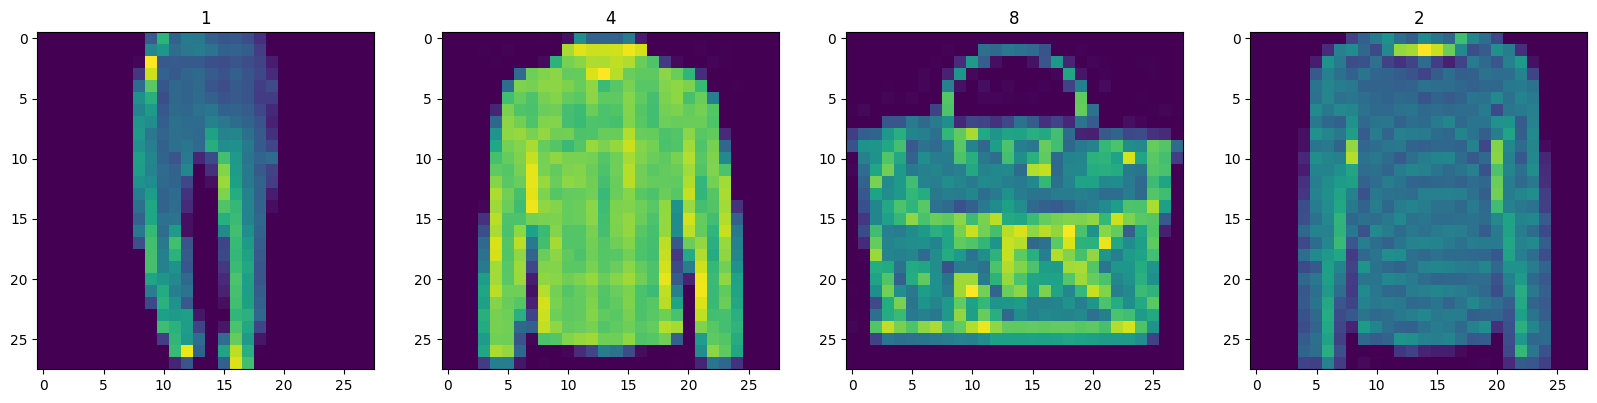

In [18]:
# Setup teh subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
# Loop four times and get images
for idx in range(4):
    # Grab a random image index
    idx_image = random.choice(range(len(train_data)))
    # Plot the image using a specific subplot
    ax[idx].imshow(train_data[idx_image])
    # Appending the image label as the plot title
    ax[idx].title.set_text(train_labels[idx_image])

In [19]:
# Scale and return images only
def scale_images(data):
    return data / 255.0

In [ ]:
# Running the dataset through the scale_images preprocessing step
dataset = scale_images(train_data)
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.cache()  # Guarda en RAM o en disco
dataset = dataset.shuffle(60000).batch(128).prefetch(64) # Batch into 128 images per sample

In [24]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28)

# Build Neural Networks

## Import Modelling Components

In [ ]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D # type: ignore

## Build Generator

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Umsampling bloxk 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [41]:
generator = build_generator()

In [42]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [61]:
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 0s 36ms/step


array([[[[0.50501066],
         [0.5046338 ],
         [0.49947554],
         ...,
         [0.5020739 ],
         [0.50536764],
         [0.500044  ]],

        [[0.5089164 ],
         [0.5002739 ],
         [0.49988058],
         ...,
         [0.50309676],
         [0.5052099 ],
         [0.49844998]],

        [[0.5080274 ],
         [0.49997163],
         [0.49414986],
         ...,
         [0.5060657 ],
         [0.50626177],
         [0.50004774]],

        ...,

        [[0.50287026],
         [0.50548005],
         [0.50804526],
         ...,
         [0.51518524],
         [0.51066357],
         [0.50892866]],

        [[0.5046718 ],
         [0.50801057],
         [0.5171089 ],
         ...,
         [0.50691897],
         [0.503159  ],
         [0.5045308 ]],

        [[0.506566  ],
         [0.5092344 ],
         [0.5139108 ],
         ...,
         [0.50254184],
         [0.50228745],
         [0.50086814]]],


       [[[0.5068846 ],
         [0.5036483 ],
         [0.50

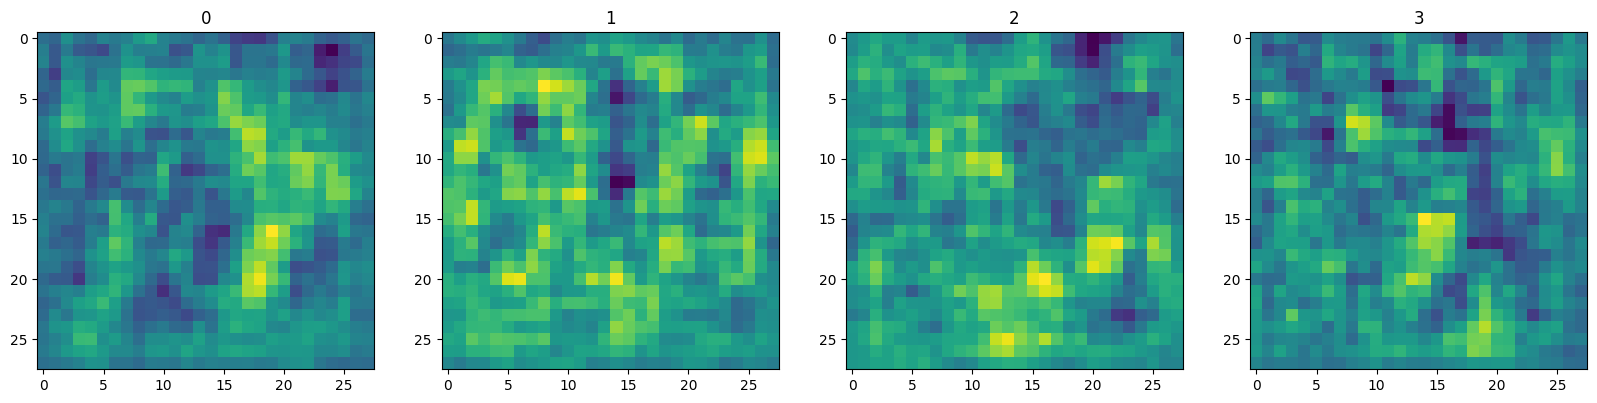

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

# Build Discriminator

In [57]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [58]:
discriminator = build_discriminator()

In [59]:
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_9 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)      

In [62]:
discriminator.predict(img)

1/1 [==============================] - 0s 208ms/step


array([[0.494473 ],
       [0.4944406],
       [0.4946734],
       [0.4945607]], dtype=float32)

# Contruct Training Loop